# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

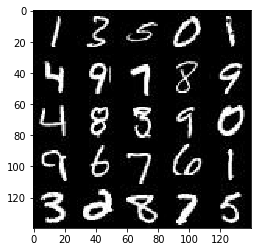

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join('./data', 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

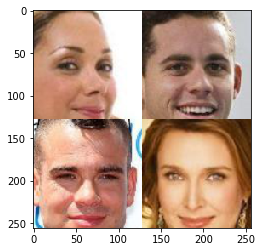

In [3]:
show_n_images = 4

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
celeb_images = helper.get_batch(glob(os.path.join(data_dir,'img_align_celeba/*.jpg'))[:show_n_images], 128, 128, 'RGB')
pyplot.imshow(helper.images_square_grid(celeb_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real=tf.placeholder(tf.float32, (None, image_width, image_height, image_channels) , name='input_real')
    input_z =tf.placeholder(tf.float32, (None, z_dim) , name='input_z')
    lr = tf.placeholder(tf.float32,  name ='learning_rate')
    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/usr/lo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
alpha = 0.01
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    kernel_size=4
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 
        x1 = tf.layers.conv2d(images, 64, kernel_size, strides=2, padding='same' )
        x1 = tf.maximum(alpha*x1, x1)
        #16*16*64
#         print(x1.shape)
        x2 = tf.layers.conv2d(x1, 128, kernel_size, strides=2, padding='same' )
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        #8*8*128
#         print(x2.shape)
        
        x3 = tf.layers.conv2d(x2, 256, kernel_size, strides=2, padding='same' )
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        #4*4*256
#         print(x3.shape)
        
        flats = tf.reshape(x3, [-1, 4*4*256])
        logits = tf.layers.dense( flats, 1,activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
alpha=0.2
keep_prob=0.75
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    kernel_size=4
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        x1=tf.layers.dense(z, 7*7*512)
        x1=tf.reshape(x1, [-1,7,7,512])
        x1=tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, keep_prob=keep_prob)
        print("x1",x1.shape)
        x2=tf.layers.conv2d_transpose(x1, 128, kernel_size, strides=2, padding='same')
        x2=tf.layers.batch_normalization(x2, training=is_train)
        x2=tf.maximum(alpha * x2, x2)
        x1 = tf.nn.dropout(x1, keep_prob=keep_prob)
        print("x2",x2.shape)
        x3=tf.layers.conv2d_transpose(x2, 32, kernel_size, strides=2, padding='same')
        x3=tf.layers.batch_normalization(x3, training=is_train)
        x3=tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        print("x3",x3.shape)
        
#         x4=tf.layers.conv2d_transpose(x3, 8, 5, strides=2, padding='same')
#         x4=tf.layers.batch_normalization(x4, training=is_train)
#         x4=tf.maximum(alpha * x4, x4)
#         print("x4",x4.shape)
        # Output layer, 28*28*3
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, kernel_size, strides=1, padding='same')
#         logits=tf.reshape(logits, [-1,28,28,out_channel_dim])
        print("logits",logits.shape)
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 5)
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 5)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model =  generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    smooth = 0.1
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, 
                                                                         labels = tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.zeros_like(d_model_fake)))
    d_loss= d_loss_real+d_loss_fake
    g_loss =tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.ones_like(d_model_fake)) )
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 4)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    show_every = 50
    print_every = 10
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
#                 print("batch_images", len(batch_images))
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
            


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)
Epoch 0/3... Discriminator Loss: 0.4382... Generator Loss: 3.2948
Epoch 0/3... Discriminator Loss: 0.5427... Generator Loss: 4.1007
Epoch 0/3... Discriminator Loss: 1.0488... Generator Loss: 3.0334
Epoch 0/3... Discriminator Loss: 0.9598... Generator Loss: 3.1318
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


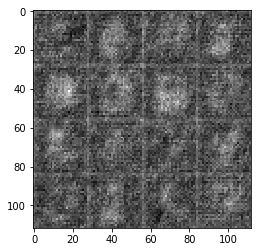

Epoch 0/3... Discriminator Loss: 0.8431... Generator Loss: 1.1941
Epoch 0/3... Discriminator Loss: 0.6143... Generator Loss: 1.7662
Epoch 0/3... Discriminator Loss: 0.6891... Generator Loss: 2.5415
Epoch 0/3... Discriminator Loss: 0.5985... Generator Loss: 2.6194
Epoch 0/3... Discriminator Loss: 0.5265... Generator Loss: 2.0510
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


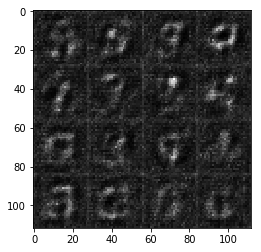

Epoch 0/3... Discriminator Loss: 0.4594... Generator Loss: 2.8044
Epoch 0/3... Discriminator Loss: 0.4244... Generator Loss: 2.7209
Epoch 0/3... Discriminator Loss: 0.3999... Generator Loss: 3.0306
Epoch 0/3... Discriminator Loss: 0.3750... Generator Loss: 3.4868
Epoch 0/3... Discriminator Loss: 0.3711... Generator Loss: 4.2680
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


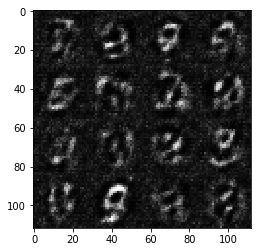

Epoch 0/3... Discriminator Loss: 0.3680... Generator Loss: 4.3349
Epoch 0/3... Discriminator Loss: 0.3571... Generator Loss: 4.4280
Epoch 0/3... Discriminator Loss: 0.3644... Generator Loss: 4.6175
Epoch 0/3... Discriminator Loss: 0.3541... Generator Loss: 4.2855
Epoch 0/3... Discriminator Loss: 0.4687... Generator Loss: 6.3358
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


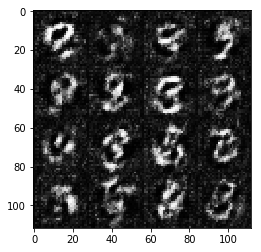

Epoch 0/3... Discriminator Loss: 0.3542... Generator Loss: 5.3308
Epoch 0/3... Discriminator Loss: 0.3440... Generator Loss: 5.4097
Epoch 0/3... Discriminator Loss: 0.3443... Generator Loss: 5.5564
Epoch 0/3... Discriminator Loss: 0.3415... Generator Loss: 5.1391
Epoch 0/3... Discriminator Loss: 0.3402... Generator Loss: 5.1961
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


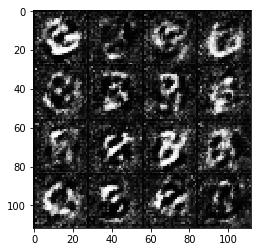

Epoch 0/3... Discriminator Loss: 0.3414... Generator Loss: 5.2769
Epoch 0/3... Discriminator Loss: 0.3412... Generator Loss: 5.3989
Epoch 0/3... Discriminator Loss: 0.3465... Generator Loss: 4.6705
Epoch 0/3... Discriminator Loss: 0.3673... Generator Loss: 5.5659
Epoch 0/3... Discriminator Loss: 0.3482... Generator Loss: 5.1170
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


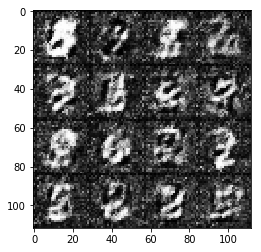

Epoch 0/3... Discriminator Loss: 0.4585... Generator Loss: 3.6173
Epoch 0/3... Discriminator Loss: 0.4117... Generator Loss: 4.6145
Epoch 0/3... Discriminator Loss: 0.3458... Generator Loss: 5.6498
Epoch 0/3... Discriminator Loss: 0.3477... Generator Loss: 5.2483
Epoch 0/3... Discriminator Loss: 0.4319... Generator Loss: 6.6271
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


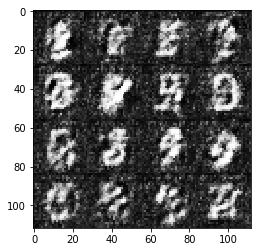

Epoch 0/3... Discriminator Loss: 0.4023... Generator Loss: 3.2283
Epoch 0/3... Discriminator Loss: 0.3581... Generator Loss: 4.0899
Epoch 0/3... Discriminator Loss: 0.3488... Generator Loss: 4.5901
Epoch 0/3... Discriminator Loss: 0.3453... Generator Loss: 4.8541
Epoch 0/3... Discriminator Loss: 0.3544... Generator Loss: 5.0301
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


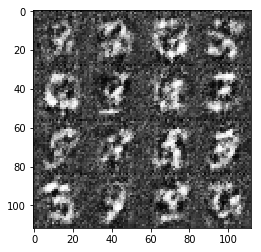

Epoch 0/3... Discriminator Loss: 0.3541... Generator Loss: 4.3952
Epoch 0/3... Discriminator Loss: 0.3411... Generator Loss: 4.8879
Epoch 0/3... Discriminator Loss: 0.3618... Generator Loss: 3.8444
Epoch 0/3... Discriminator Loss: 0.3962... Generator Loss: 3.0915
Epoch 0/3... Discriminator Loss: 0.4384... Generator Loss: 2.5969
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


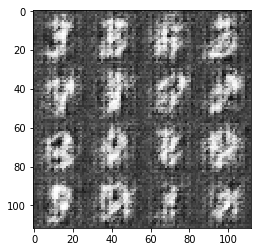

Epoch 0/3... Discriminator Loss: 0.9421... Generator Loss: 0.9388
Epoch 0/3... Discriminator Loss: 0.4016... Generator Loss: 3.3124
Epoch 1/3... Discriminator Loss: 0.5151... Generator Loss: 2.1033
Epoch 1/3... Discriminator Loss: 2.3429... Generator Loss: 0.2181
Epoch 1/3... Discriminator Loss: 0.4997... Generator Loss: 3.0316
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


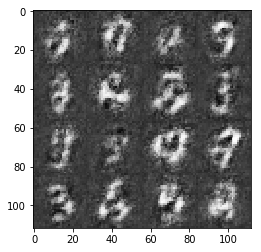

Epoch 1/3... Discriminator Loss: 0.4834... Generator Loss: 2.1675
Epoch 1/3... Discriminator Loss: 0.4233... Generator Loss: 3.4423
Epoch 1/3... Discriminator Loss: 1.4990... Generator Loss: 0.4975
Epoch 1/3... Discriminator Loss: 0.4485... Generator Loss: 2.6362
Epoch 1/3... Discriminator Loss: 0.4076... Generator Loss: 3.1572
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


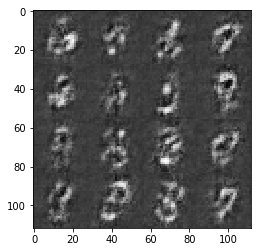

Epoch 1/3... Discriminator Loss: 0.4158... Generator Loss: 2.9805
Epoch 1/3... Discriminator Loss: 0.7666... Generator Loss: 1.4040
Epoch 1/3... Discriminator Loss: 0.4415... Generator Loss: 2.7907
Epoch 1/3... Discriminator Loss: 0.4271... Generator Loss: 3.3231
Epoch 1/3... Discriminator Loss: 0.4139... Generator Loss: 3.6368
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


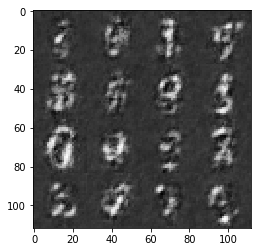

Epoch 1/3... Discriminator Loss: 0.4256... Generator Loss: 2.7022
Epoch 1/3... Discriminator Loss: 0.4200... Generator Loss: 3.7008
Epoch 1/3... Discriminator Loss: 0.4872... Generator Loss: 2.1828
Epoch 1/3... Discriminator Loss: 0.4058... Generator Loss: 3.6200
Epoch 1/3... Discriminator Loss: 0.4015... Generator Loss: 3.8276
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


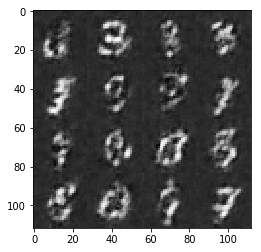

Epoch 1/3... Discriminator Loss: 0.4688... Generator Loss: 2.4176
Epoch 1/3... Discriminator Loss: 0.3932... Generator Loss: 3.6182
Epoch 1/3... Discriminator Loss: 0.6701... Generator Loss: 1.5874
Epoch 1/3... Discriminator Loss: 0.5139... Generator Loss: 2.0323
Epoch 1/3... Discriminator Loss: 0.4111... Generator Loss: 2.9285
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


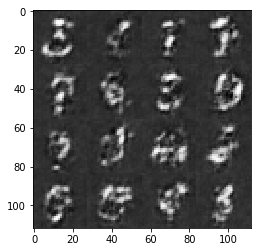

Epoch 1/3... Discriminator Loss: 0.4067... Generator Loss: 3.3585
Epoch 1/3... Discriminator Loss: 0.4070... Generator Loss: 3.0845
Epoch 1/3... Discriminator Loss: 0.3899... Generator Loss: 3.2028
Epoch 1/3... Discriminator Loss: 0.3863... Generator Loss: 3.7595
Epoch 1/3... Discriminator Loss: 0.3907... Generator Loss: 3.7284
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


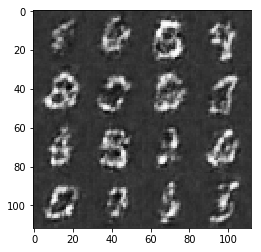

Epoch 1/3... Discriminator Loss: 0.3764... Generator Loss: 3.3361
Epoch 1/3... Discriminator Loss: 0.3984... Generator Loss: 3.0224
Epoch 1/3... Discriminator Loss: 0.3823... Generator Loss: 3.4419
Epoch 1/3... Discriminator Loss: 0.3616... Generator Loss: 4.2623
Epoch 1/3... Discriminator Loss: 0.3712... Generator Loss: 3.9007
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


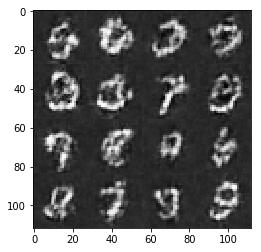

Epoch 1/3... Discriminator Loss: 1.0118... Generator Loss: 0.9557
Epoch 1/3... Discriminator Loss: 0.4198... Generator Loss: 3.1291
Epoch 1/3... Discriminator Loss: 0.4408... Generator Loss: 2.6264
Epoch 1/3... Discriminator Loss: 0.4039... Generator Loss: 2.9859
Epoch 1/3... Discriminator Loss: 0.3779... Generator Loss: 3.4978
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


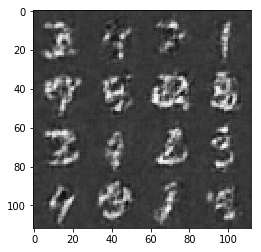

Epoch 1/3... Discriminator Loss: 0.3782... Generator Loss: 3.5497
Epoch 1/3... Discriminator Loss: 0.3744... Generator Loss: 3.4261
Epoch 1/3... Discriminator Loss: 0.4624... Generator Loss: 2.3819
Epoch 1/3... Discriminator Loss: 0.3747... Generator Loss: 3.5291
Epoch 1/3... Discriminator Loss: 0.3675... Generator Loss: 3.7174
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


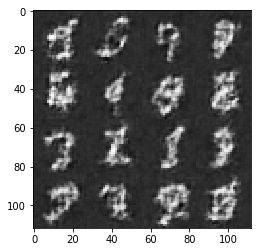

Epoch 1/3... Discriminator Loss: 0.3620... Generator Loss: 4.6726
Epoch 1/3... Discriminator Loss: 0.3664... Generator Loss: 3.8707
Epoch 1/3... Discriminator Loss: 0.3576... Generator Loss: 4.7406
Epoch 1/3... Discriminator Loss: 0.3585... Generator Loss: 4.2110
Epoch 2/3... Discriminator Loss: 0.3686... Generator Loss: 3.6393
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


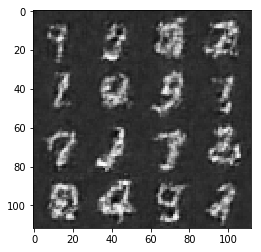

Epoch 2/3... Discriminator Loss: 0.3735... Generator Loss: 3.9183
Epoch 2/3... Discriminator Loss: 0.3613... Generator Loss: 3.9024
Epoch 2/3... Discriminator Loss: 0.3638... Generator Loss: 4.0238
Epoch 2/3... Discriminator Loss: 0.3665... Generator Loss: 3.9198
Epoch 2/3... Discriminator Loss: 0.3714... Generator Loss: 4.1389
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


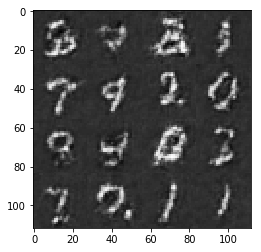

Epoch 2/3... Discriminator Loss: 0.3478... Generator Loss: 4.6576
Epoch 2/3... Discriminator Loss: 0.3859... Generator Loss: 4.3863
Epoch 2/3... Discriminator Loss: 0.3689... Generator Loss: 4.6093
Epoch 2/3... Discriminator Loss: 0.3680... Generator Loss: 3.5681
Epoch 2/3... Discriminator Loss: 0.3633... Generator Loss: 4.3975
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


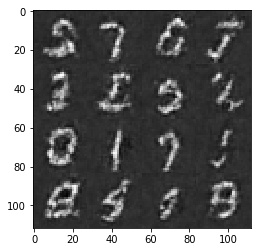

Epoch 2/3... Discriminator Loss: 0.3962... Generator Loss: 4.1937
Epoch 2/3... Discriminator Loss: 1.8808... Generator Loss: 0.3794
Epoch 2/3... Discriminator Loss: 0.5267... Generator Loss: 2.0908
Epoch 2/3... Discriminator Loss: 0.4536... Generator Loss: 2.5418
Epoch 2/3... Discriminator Loss: 0.3985... Generator Loss: 3.1722
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


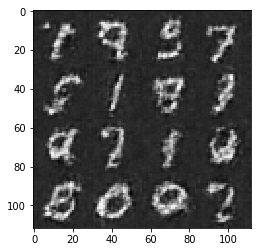

Epoch 2/3... Discriminator Loss: 0.4011... Generator Loss: 2.8992
Epoch 2/3... Discriminator Loss: 0.3821... Generator Loss: 3.3731
Epoch 2/3... Discriminator Loss: 0.3777... Generator Loss: 3.2701
Epoch 2/3... Discriminator Loss: 0.4472... Generator Loss: 2.5104
Epoch 2/3... Discriminator Loss: 0.3683... Generator Loss: 3.5605
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


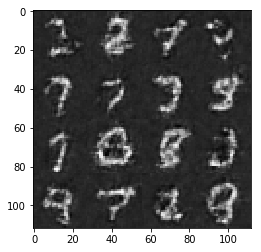

Epoch 2/3... Discriminator Loss: 0.3579... Generator Loss: 3.9462
Epoch 2/3... Discriminator Loss: 0.3656... Generator Loss: 3.7067
Epoch 2/3... Discriminator Loss: 0.3690... Generator Loss: 3.7389
Epoch 2/3... Discriminator Loss: 0.3557... Generator Loss: 4.1097
Epoch 2/3... Discriminator Loss: 0.3673... Generator Loss: 3.5683
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


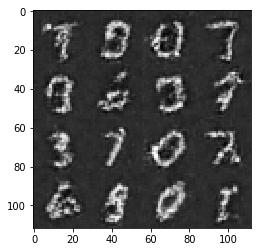

Epoch 2/3... Discriminator Loss: 0.3457... Generator Loss: 4.7166
Epoch 2/3... Discriminator Loss: 0.3669... Generator Loss: 3.6289
Epoch 2/3... Discriminator Loss: 0.3651... Generator Loss: 4.0972
Epoch 2/3... Discriminator Loss: 0.3638... Generator Loss: 3.9590
Epoch 2/3... Discriminator Loss: 0.3660... Generator Loss: 4.3003
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


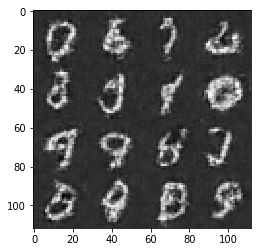

Epoch 2/3... Discriminator Loss: 0.3646... Generator Loss: 3.5047
Epoch 2/3... Discriminator Loss: 0.3504... Generator Loss: 4.9067
Epoch 2/3... Discriminator Loss: 15.9353... Generator Loss: 16.7763
Epoch 2/3... Discriminator Loss: 0.9342... Generator Loss: 1.8353
Epoch 2/3... Discriminator Loss: 1.1994... Generator Loss: 1.0596
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


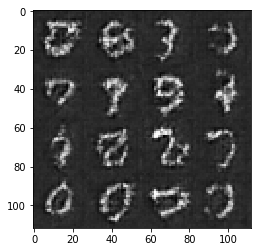

Epoch 2/3... Discriminator Loss: 0.9936... Generator Loss: 1.0930
Epoch 2/3... Discriminator Loss: 0.9579... Generator Loss: 2.1358
Epoch 2/3... Discriminator Loss: 0.6918... Generator Loss: 1.8118
Epoch 2/3... Discriminator Loss: 0.8961... Generator Loss: 2.6228
Epoch 2/3... Discriminator Loss: 0.7376... Generator Loss: 2.9402
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


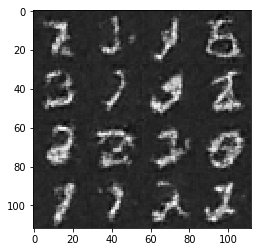

Epoch 2/3... Discriminator Loss: 0.5851... Generator Loss: 2.7213
Epoch 2/3... Discriminator Loss: 0.4728... Generator Loss: 2.3485
Epoch 2/3... Discriminator Loss: 0.4541... Generator Loss: 2.6123
Epoch 2/3... Discriminator Loss: 0.5597... Generator Loss: 3.7769
Epoch 2/3... Discriminator Loss: 0.4144... Generator Loss: 3.4065
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


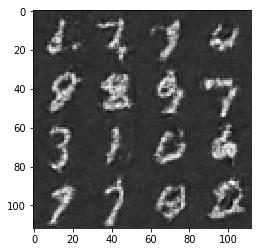

Epoch 2/3... Discriminator Loss: 0.3960... Generator Loss: 3.0434
CPU times: user 2min 43s, sys: 1min 21s, total: 4min 5s
Wall time: 4min 45s


In [12]:
%%time
batch_size = 128
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5
alpha=0.2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3
# tf.reset_default_graph()
        
mnist_dataset = helper.Dataset('mnist', glob(os.path.join('./data', 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

finished loading images.
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)
Epoch 0/1... Discriminator Loss: 0.5487... Generator Loss: 2.2755
Epoch 0/1... Discriminator Loss: 0.4929... Generator Loss: 2.4163
Epoch 0/1... Discriminator Loss: 0.4101... Generator Loss: 3.2213
Epoch 0/1... Discriminator Loss: 0.4181... Generator Loss: 3.6277
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


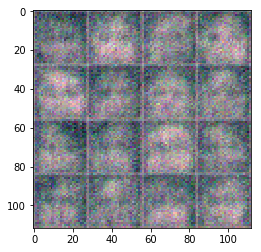

Epoch 0/1... Discriminator Loss: 0.9488... Generator Loss: 1.0197
Epoch 0/1... Discriminator Loss: 0.4449... Generator Loss: 2.9943
Epoch 0/1... Discriminator Loss: 0.4477... Generator Loss: 2.9232
Epoch 0/1... Discriminator Loss: 0.4097... Generator Loss: 3.5769
Epoch 0/1... Discriminator Loss: 0.4161... Generator Loss: 3.1917
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


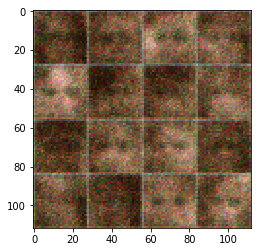

Epoch 0/1... Discriminator Loss: 0.3755... Generator Loss: 3.7308
Epoch 0/1... Discriminator Loss: 0.3589... Generator Loss: 4.1847
Epoch 0/1... Discriminator Loss: 0.3791... Generator Loss: 4.8487
Epoch 0/1... Discriminator Loss: 0.3610... Generator Loss: 4.0552
Epoch 0/1... Discriminator Loss: 0.3766... Generator Loss: 3.8271
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


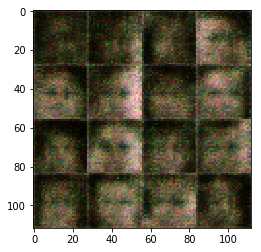

Epoch 0/1... Discriminator Loss: 0.3502... Generator Loss: 5.1067
Epoch 0/1... Discriminator Loss: 0.4268... Generator Loss: 3.3079
Epoch 0/1... Discriminator Loss: 0.3400... Generator Loss: 4.9641
Epoch 0/1... Discriminator Loss: 0.3508... Generator Loss: 4.9005
Epoch 0/1... Discriminator Loss: 0.4694... Generator Loss: 2.9661
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


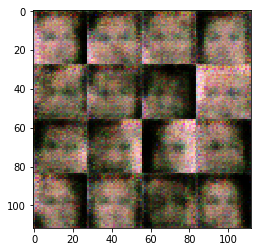

Epoch 0/1... Discriminator Loss: 0.3507... Generator Loss: 4.1723
Epoch 0/1... Discriminator Loss: 0.3449... Generator Loss: 5.0661
Epoch 0/1... Discriminator Loss: 0.4586... Generator Loss: 3.0731
Epoch 0/1... Discriminator Loss: 0.3437... Generator Loss: 5.2653
Epoch 0/1... Discriminator Loss: 0.3420... Generator Loss: 5.7304
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


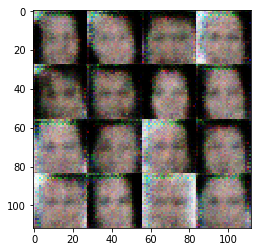

Epoch 0/1... Discriminator Loss: 0.3813... Generator Loss: 3.7154
Epoch 0/1... Discriminator Loss: 0.3490... Generator Loss: 4.4088
Epoch 0/1... Discriminator Loss: 0.3434... Generator Loss: 4.9786
Epoch 0/1... Discriminator Loss: 0.4804... Generator Loss: 4.7574
Epoch 0/1... Discriminator Loss: 0.3750... Generator Loss: 3.9596
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


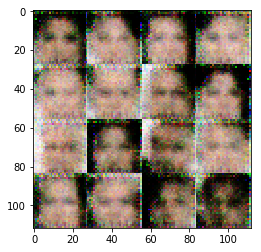

Epoch 0/1... Discriminator Loss: 0.3506... Generator Loss: 5.5514
Epoch 0/1... Discriminator Loss: 0.3440... Generator Loss: 5.4088
Epoch 0/1... Discriminator Loss: 0.3385... Generator Loss: 4.9474
Epoch 0/1... Discriminator Loss: 0.3481... Generator Loss: 4.4839
Epoch 0/1... Discriminator Loss: 0.3589... Generator Loss: 4.6572
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


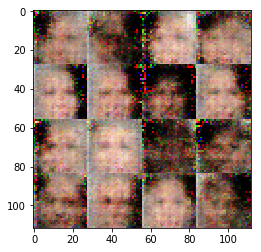

Epoch 0/1... Discriminator Loss: 0.3529... Generator Loss: 4.6974
Epoch 0/1... Discriminator Loss: 0.3633... Generator Loss: 4.6106
Epoch 0/1... Discriminator Loss: 0.4530... Generator Loss: 5.9360
Epoch 0/1... Discriminator Loss: 0.3858... Generator Loss: 3.9423
Epoch 0/1... Discriminator Loss: 0.6648... Generator Loss: 2.1359
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


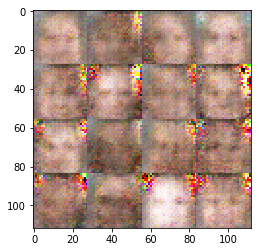

Epoch 0/1... Discriminator Loss: 0.5327... Generator Loss: 2.7635
Epoch 0/1... Discriminator Loss: 0.3999... Generator Loss: 4.8441
Epoch 0/1... Discriminator Loss: 0.3967... Generator Loss: 3.6412
Epoch 0/1... Discriminator Loss: 0.3899... Generator Loss: 3.4971
Epoch 0/1... Discriminator Loss: 0.3781... Generator Loss: 4.0676
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


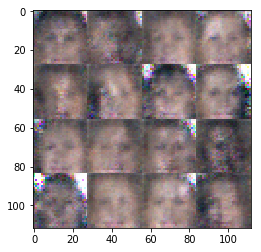

Epoch 0/1... Discriminator Loss: 0.4304... Generator Loss: 4.3899
Epoch 0/1... Discriminator Loss: 0.4009... Generator Loss: 3.2400
Epoch 0/1... Discriminator Loss: 0.3717... Generator Loss: 4.3001
Epoch 0/1... Discriminator Loss: 0.4260... Generator Loss: 3.7775
Epoch 0/1... Discriminator Loss: 0.4232... Generator Loss: 3.4852
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


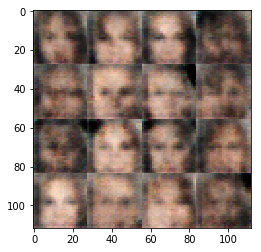

Epoch 0/1... Discriminator Loss: 0.5459... Generator Loss: 2.5280
Epoch 0/1... Discriminator Loss: 0.4300... Generator Loss: 3.6297
Epoch 0/1... Discriminator Loss: 0.4246... Generator Loss: 3.3813
Epoch 0/1... Discriminator Loss: 0.4496... Generator Loss: 2.8611
Epoch 0/1... Discriminator Loss: 0.4456... Generator Loss: 3.0947
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


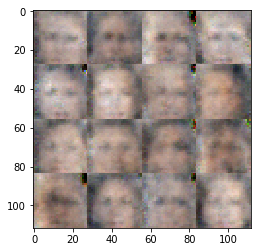

Epoch 0/1... Discriminator Loss: 0.4149... Generator Loss: 3.5040
Epoch 0/1... Discriminator Loss: 0.3968... Generator Loss: 3.7751
Epoch 0/1... Discriminator Loss: 0.4302... Generator Loss: 4.1347
Epoch 0/1... Discriminator Loss: 0.4935... Generator Loss: 2.6318
Epoch 0/1... Discriminator Loss: 2.1002... Generator Loss: 0.4231
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


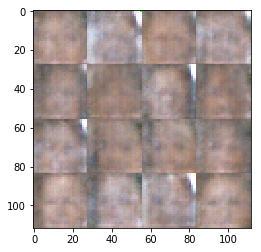

Epoch 0/1... Discriminator Loss: 0.7684... Generator Loss: 1.8167
Epoch 0/1... Discriminator Loss: 0.5556... Generator Loss: 2.4861
Epoch 0/1... Discriminator Loss: 0.4387... Generator Loss: 3.2577
Epoch 0/1... Discriminator Loss: 0.6714... Generator Loss: 2.7401
Epoch 0/1... Discriminator Loss: 0.6217... Generator Loss: 1.6272
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


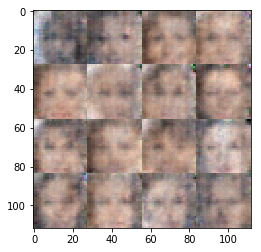

Epoch 0/1... Discriminator Loss: 0.6152... Generator Loss: 3.1988
Epoch 0/1... Discriminator Loss: 0.7358... Generator Loss: 1.6048
Epoch 0/1... Discriminator Loss: 0.8837... Generator Loss: 1.3230
Epoch 0/1... Discriminator Loss: 0.9124... Generator Loss: 1.9232
Epoch 0/1... Discriminator Loss: 0.9898... Generator Loss: 1.8222
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


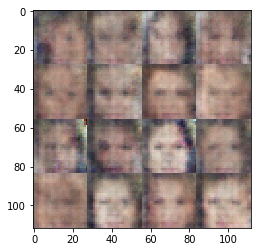

Epoch 0/1... Discriminator Loss: 1.3331... Generator Loss: 0.5837
Epoch 0/1... Discriminator Loss: 1.1985... Generator Loss: 1.9568
Epoch 0/1... Discriminator Loss: 1.3373... Generator Loss: 2.1418
Epoch 0/1... Discriminator Loss: 0.9298... Generator Loss: 1.2752
Epoch 0/1... Discriminator Loss: 1.1393... Generator Loss: 0.9632
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


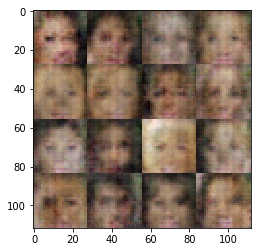

Epoch 0/1... Discriminator Loss: 0.8343... Generator Loss: 1.6794
Epoch 0/1... Discriminator Loss: 1.2122... Generator Loss: 1.1492
Epoch 0/1... Discriminator Loss: 1.0190... Generator Loss: 1.1176
Epoch 0/1... Discriminator Loss: 1.0746... Generator Loss: 0.9765
Epoch 0/1... Discriminator Loss: 1.1286... Generator Loss: 0.9776
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


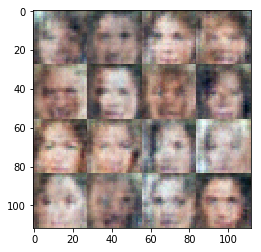

Epoch 0/1... Discriminator Loss: 1.1298... Generator Loss: 0.8425
Epoch 0/1... Discriminator Loss: 0.9389... Generator Loss: 1.5355
Epoch 0/1... Discriminator Loss: 1.1597... Generator Loss: 1.3616
Epoch 0/1... Discriminator Loss: 1.0280... Generator Loss: 0.8615
Epoch 0/1... Discriminator Loss: 1.2060... Generator Loss: 0.6966
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


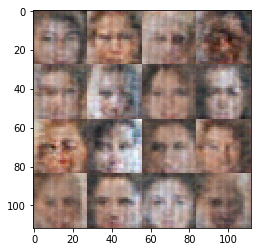

Epoch 0/1... Discriminator Loss: 0.9424... Generator Loss: 1.0784
Epoch 0/1... Discriminator Loss: 1.0640... Generator Loss: 1.0383
Epoch 0/1... Discriminator Loss: 1.1518... Generator Loss: 1.0854
Epoch 0/1... Discriminator Loss: 1.0015... Generator Loss: 1.4840
Epoch 0/1... Discriminator Loss: 1.0467... Generator Loss: 1.5389
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


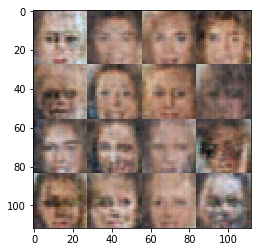

Epoch 0/1... Discriminator Loss: 0.9793... Generator Loss: 1.3337
Epoch 0/1... Discriminator Loss: 1.0377... Generator Loss: 1.0522
Epoch 0/1... Discriminator Loss: 0.9507... Generator Loss: 1.5542
Epoch 0/1... Discriminator Loss: 1.2657... Generator Loss: 0.6853
Epoch 0/1... Discriminator Loss: 0.8915... Generator Loss: 1.8030
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


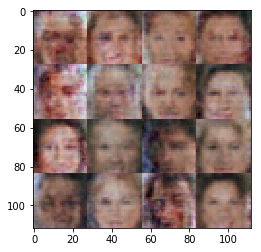

Epoch 0/1... Discriminator Loss: 1.3600... Generator Loss: 2.5144
Epoch 0/1... Discriminator Loss: 0.9991... Generator Loss: 1.0941
Epoch 0/1... Discriminator Loss: 1.1286... Generator Loss: 0.8172
Epoch 0/1... Discriminator Loss: 1.1821... Generator Loss: 0.7858
Epoch 0/1... Discriminator Loss: 1.0797... Generator Loss: 1.4817
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


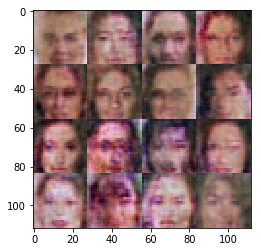

Epoch 0/1... Discriminator Loss: 1.4403... Generator Loss: 0.5214
Epoch 0/1... Discriminator Loss: 0.9871... Generator Loss: 1.2592
Epoch 0/1... Discriminator Loss: 0.9696... Generator Loss: 1.2614
Epoch 0/1... Discriminator Loss: 1.0583... Generator Loss: 1.1258
Epoch 0/1... Discriminator Loss: 1.1120... Generator Loss: 0.8159
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


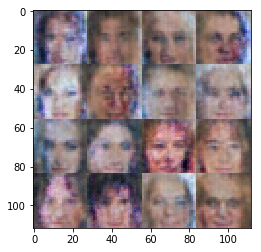

Epoch 0/1... Discriminator Loss: 1.0447... Generator Loss: 1.5289
Epoch 0/1... Discriminator Loss: 0.9875... Generator Loss: 1.2618
Epoch 0/1... Discriminator Loss: 0.8738... Generator Loss: 1.7385
Epoch 0/1... Discriminator Loss: 0.9026... Generator Loss: 1.6207
Epoch 0/1... Discriminator Loss: 0.9754... Generator Loss: 1.2452
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


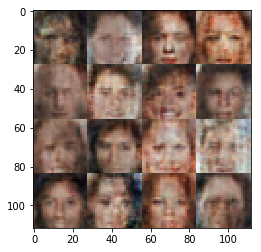

Epoch 0/1... Discriminator Loss: 1.0159... Generator Loss: 1.0183
Epoch 0/1... Discriminator Loss: 1.0365... Generator Loss: 0.8634
Epoch 0/1... Discriminator Loss: 1.1587... Generator Loss: 0.6643
Epoch 0/1... Discriminator Loss: 1.0438... Generator Loss: 1.5294
Epoch 0/1... Discriminator Loss: 0.9707... Generator Loss: 1.3925
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


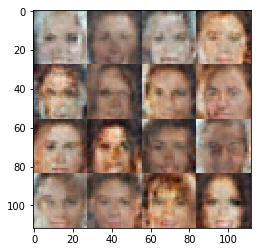

Epoch 0/1... Discriminator Loss: 1.2734... Generator Loss: 0.5591
Epoch 0/1... Discriminator Loss: 0.9005... Generator Loss: 1.3984
Epoch 0/1... Discriminator Loss: 1.0279... Generator Loss: 1.2318
Epoch 0/1... Discriminator Loss: 0.8925... Generator Loss: 1.4182
Epoch 0/1... Discriminator Loss: 1.0088... Generator Loss: 0.7459
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


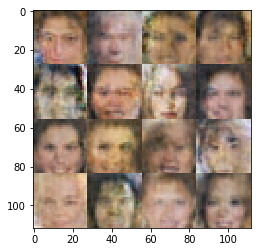

Epoch 0/1... Discriminator Loss: 1.0331... Generator Loss: 1.0879
Epoch 0/1... Discriminator Loss: 1.0974... Generator Loss: 1.3034
Epoch 0/1... Discriminator Loss: 1.0014... Generator Loss: 1.1471
Epoch 0/1... Discriminator Loss: 0.9608... Generator Loss: 1.8703
Epoch 0/1... Discriminator Loss: 1.2168... Generator Loss: 1.0162
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


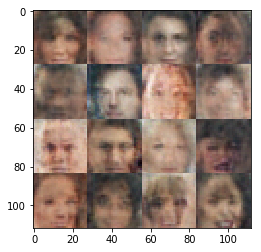

Epoch 0/1... Discriminator Loss: 0.8745... Generator Loss: 1.1722
Epoch 0/1... Discriminator Loss: 0.9076... Generator Loss: 1.3851
Epoch 0/1... Discriminator Loss: 2.0182... Generator Loss: 0.3068
Epoch 0/1... Discriminator Loss: 1.2501... Generator Loss: 0.6518
Epoch 0/1... Discriminator Loss: 0.9178... Generator Loss: 1.1565
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


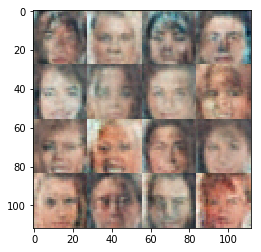

Epoch 0/1... Discriminator Loss: 1.0443... Generator Loss: 1.1670
Epoch 0/1... Discriminator Loss: 1.3550... Generator Loss: 2.4111
Epoch 0/1... Discriminator Loss: 1.2869... Generator Loss: 0.5819
Epoch 0/1... Discriminator Loss: 1.0992... Generator Loss: 1.0729
Epoch 0/1... Discriminator Loss: 1.0243... Generator Loss: 1.1505
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


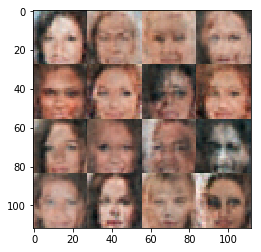

Epoch 0/1... Discriminator Loss: 0.8607... Generator Loss: 1.3590
Epoch 0/1... Discriminator Loss: 0.8583... Generator Loss: 1.2617
Epoch 0/1... Discriminator Loss: 0.9164... Generator Loss: 1.7537
Epoch 0/1... Discriminator Loss: 1.0057... Generator Loss: 0.8972
Epoch 0/1... Discriminator Loss: 1.0612... Generator Loss: 0.9596
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


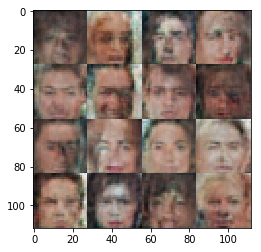

Epoch 0/1... Discriminator Loss: 0.8975... Generator Loss: 1.2373
Epoch 0/1... Discriminator Loss: 1.2157... Generator Loss: 0.6512
Epoch 0/1... Discriminator Loss: 0.9884... Generator Loss: 1.2087
Epoch 0/1... Discriminator Loss: 1.1488... Generator Loss: 0.6628
Epoch 0/1... Discriminator Loss: 1.1121... Generator Loss: 1.0001
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


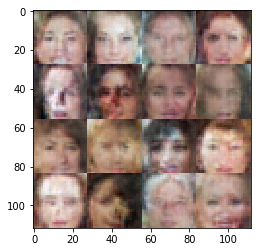

Epoch 0/1... Discriminator Loss: 1.1624... Generator Loss: 0.8333
Epoch 0/1... Discriminator Loss: 0.9205... Generator Loss: 1.1164
Epoch 0/1... Discriminator Loss: 0.9907... Generator Loss: 1.8334
Epoch 0/1... Discriminator Loss: 1.5717... Generator Loss: 0.4256
Epoch 0/1... Discriminator Loss: 1.0851... Generator Loss: 0.8452
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


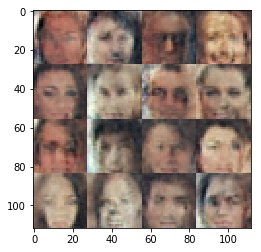

Epoch 0/1... Discriminator Loss: 1.4351... Generator Loss: 0.6364
Epoch 0/1... Discriminator Loss: 0.9349... Generator Loss: 1.5179
Epoch 0/1... Discriminator Loss: 1.2559... Generator Loss: 0.6548
Epoch 0/1... Discriminator Loss: 1.1074... Generator Loss: 0.9971
Epoch 0/1... Discriminator Loss: 0.8976... Generator Loss: 1.2214
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


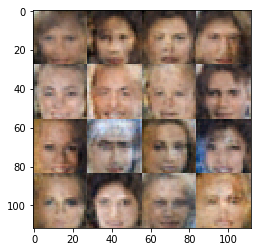

Epoch 0/1... Discriminator Loss: 0.8926... Generator Loss: 1.8118
Epoch 0/1... Discriminator Loss: 0.7962... Generator Loss: 1.3799
Epoch 0/1... Discriminator Loss: 0.9527... Generator Loss: 1.0331
Epoch 0/1... Discriminator Loss: 0.9737... Generator Loss: 0.9949
Epoch 0/1... Discriminator Loss: 0.9579... Generator Loss: 1.1197
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


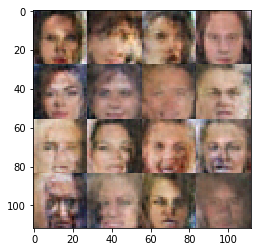

Epoch 0/1... Discriminator Loss: 0.9317... Generator Loss: 1.0253
Epoch 0/1... Discriminator Loss: 0.9422... Generator Loss: 1.6581
Epoch 0/1... Discriminator Loss: 1.0711... Generator Loss: 1.4807
Epoch 0/1... Discriminator Loss: 1.1935... Generator Loss: 2.4336
Epoch 0/1... Discriminator Loss: 1.1523... Generator Loss: 0.9428
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


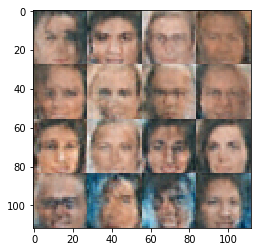

Epoch 0/1... Discriminator Loss: 1.1027... Generator Loss: 1.2653
Epoch 0/1... Discriminator Loss: 0.6813... Generator Loss: 1.6015
Epoch 0/1... Discriminator Loss: 0.8721... Generator Loss: 1.2048
Epoch 0/1... Discriminator Loss: 1.0346... Generator Loss: 1.6296
Epoch 0/1... Discriminator Loss: 1.2160... Generator Loss: 1.6329
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


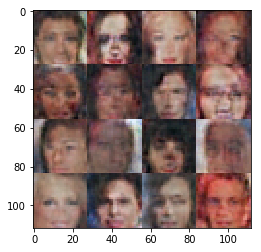

Epoch 0/1... Discriminator Loss: 1.0391... Generator Loss: 1.3655
Epoch 0/1... Discriminator Loss: 0.9210... Generator Loss: 1.7564
Epoch 0/1... Discriminator Loss: 0.8394... Generator Loss: 1.0757
Epoch 0/1... Discriminator Loss: 1.4315... Generator Loss: 0.4894
Epoch 0/1... Discriminator Loss: 1.0258... Generator Loss: 0.9985
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


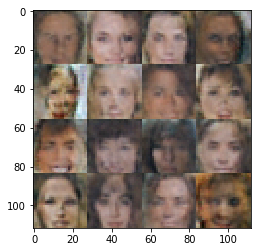

Epoch 0/1... Discriminator Loss: 0.8600... Generator Loss: 1.4232
Epoch 0/1... Discriminator Loss: 0.8307... Generator Loss: 1.7726
Epoch 0/1... Discriminator Loss: 1.1032... Generator Loss: 1.1984
Epoch 0/1... Discriminator Loss: 0.8680... Generator Loss: 1.3503
Epoch 0/1... Discriminator Loss: 1.0218... Generator Loss: 1.5878
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


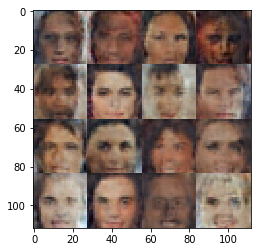

Epoch 0/1... Discriminator Loss: 0.7923... Generator Loss: 1.3737
Epoch 0/1... Discriminator Loss: 1.2364... Generator Loss: 0.6132
Epoch 0/1... Discriminator Loss: 0.9918... Generator Loss: 0.8363
Epoch 0/1... Discriminator Loss: 1.0183... Generator Loss: 0.8545
Epoch 0/1... Discriminator Loss: 0.8664... Generator Loss: 1.5298
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


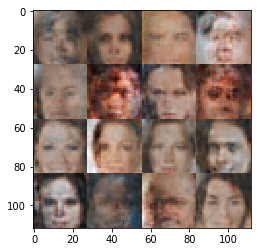

Epoch 0/1... Discriminator Loss: 0.9779... Generator Loss: 0.9825
Epoch 0/1... Discriminator Loss: 0.9269... Generator Loss: 1.0323
Epoch 0/1... Discriminator Loss: 0.8772... Generator Loss: 1.1243
Epoch 0/1... Discriminator Loss: 1.1653... Generator Loss: 1.0254
Epoch 0/1... Discriminator Loss: 1.0599... Generator Loss: 1.1862
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


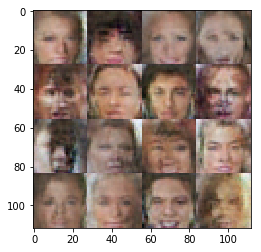

Epoch 0/1... Discriminator Loss: 0.7473... Generator Loss: 1.5236
Epoch 0/1... Discriminator Loss: 1.0159... Generator Loss: 1.5844
Epoch 0/1... Discriminator Loss: 0.9802... Generator Loss: 0.9211
Epoch 0/1... Discriminator Loss: 1.3302... Generator Loss: 0.9760
Epoch 0/1... Discriminator Loss: 1.1656... Generator Loss: 0.8145
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


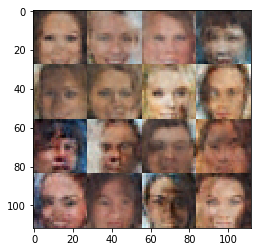

Epoch 0/1... Discriminator Loss: 1.1850... Generator Loss: 1.2645
Epoch 0/1... Discriminator Loss: 0.9172... Generator Loss: 1.5509
Epoch 0/1... Discriminator Loss: 1.1079... Generator Loss: 1.0202
Epoch 0/1... Discriminator Loss: 1.1100... Generator Loss: 1.0619
Epoch 0/1... Discriminator Loss: 1.1688... Generator Loss: 0.6774
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


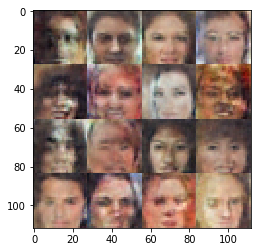

Epoch 0/1... Discriminator Loss: 1.1464... Generator Loss: 1.5237
Epoch 0/1... Discriminator Loss: 1.0325... Generator Loss: 0.8186
Epoch 0/1... Discriminator Loss: 0.8617... Generator Loss: 1.3574
Epoch 0/1... Discriminator Loss: 1.1251... Generator Loss: 0.7522
Epoch 0/1... Discriminator Loss: 1.0629... Generator Loss: 0.8334
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


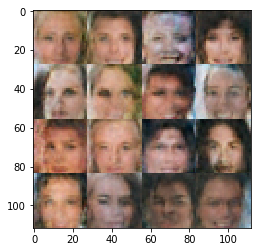

Epoch 0/1... Discriminator Loss: 1.1828... Generator Loss: 0.5653
Epoch 0/1... Discriminator Loss: 1.1213... Generator Loss: 0.7504
Epoch 0/1... Discriminator Loss: 0.9178... Generator Loss: 0.9967
Epoch 0/1... Discriminator Loss: 0.8532... Generator Loss: 1.3109
Epoch 0/1... Discriminator Loss: 1.1470... Generator Loss: 1.4077
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


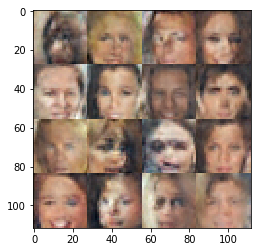

Epoch 0/1... Discriminator Loss: 0.9518... Generator Loss: 1.5937
Epoch 0/1... Discriminator Loss: 1.1788... Generator Loss: 0.6781
Epoch 0/1... Discriminator Loss: 1.2843... Generator Loss: 0.6972
Epoch 0/1... Discriminator Loss: 1.1141... Generator Loss: 0.6672
Epoch 0/1... Discriminator Loss: 0.8185... Generator Loss: 1.3597
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


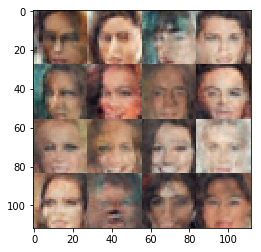

Epoch 0/1... Discriminator Loss: 0.8938... Generator Loss: 1.3475
Epoch 0/1... Discriminator Loss: 1.0387... Generator Loss: 1.4412
Epoch 0/1... Discriminator Loss: 0.9292... Generator Loss: 1.3776
Epoch 0/1... Discriminator Loss: 0.8444... Generator Loss: 1.2685
Epoch 0/1... Discriminator Loss: 1.1272... Generator Loss: 0.7328
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


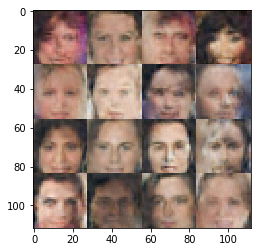

Epoch 0/1... Discriminator Loss: 1.1333... Generator Loss: 0.7756
Epoch 0/1... Discriminator Loss: 1.0041... Generator Loss: 0.9519
Epoch 0/1... Discriminator Loss: 0.8968... Generator Loss: 1.0267
Epoch 0/1... Discriminator Loss: 0.9602... Generator Loss: 0.9311
Epoch 0/1... Discriminator Loss: 1.2615... Generator Loss: 0.6613
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


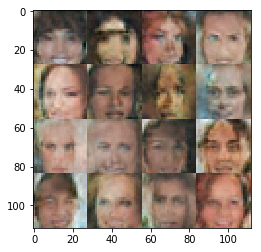

Epoch 0/1... Discriminator Loss: 0.9400... Generator Loss: 1.3392
Epoch 0/1... Discriminator Loss: 0.9630... Generator Loss: 0.8463
Epoch 0/1... Discriminator Loss: 0.8015... Generator Loss: 1.4200
Epoch 0/1... Discriminator Loss: 0.8694... Generator Loss: 1.3174
Epoch 0/1... Discriminator Loss: 1.3095... Generator Loss: 0.6235
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


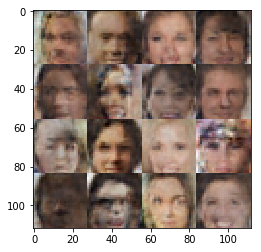

Epoch 0/1... Discriminator Loss: 0.8902... Generator Loss: 1.1019
Epoch 0/1... Discriminator Loss: 0.7929... Generator Loss: 1.5649
Epoch 0/1... Discriminator Loss: 0.9560... Generator Loss: 1.5231
Epoch 0/1... Discriminator Loss: 0.9481... Generator Loss: 0.9131
Epoch 0/1... Discriminator Loss: 0.8691... Generator Loss: 1.0686
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


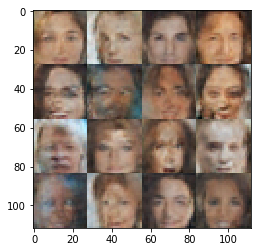

Epoch 0/1... Discriminator Loss: 1.2979... Generator Loss: 0.5615
Epoch 0/1... Discriminator Loss: 0.9010... Generator Loss: 1.4445
Epoch 0/1... Discriminator Loss: 1.0187... Generator Loss: 0.9760
Epoch 0/1... Discriminator Loss: 1.0024... Generator Loss: 0.8622
Epoch 0/1... Discriminator Loss: 0.9858... Generator Loss: 0.9785
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


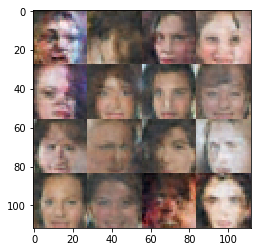

Epoch 0/1... Discriminator Loss: 0.9244... Generator Loss: 1.0764
Epoch 0/1... Discriminator Loss: 0.9129... Generator Loss: 1.0900
Epoch 0/1... Discriminator Loss: 0.9815... Generator Loss: 1.4188
Epoch 0/1... Discriminator Loss: 0.7907... Generator Loss: 1.4769
Epoch 0/1... Discriminator Loss: 1.0719... Generator Loss: 0.7380
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


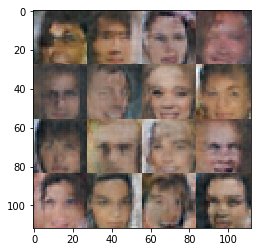

Epoch 0/1... Discriminator Loss: 0.9225... Generator Loss: 1.2636
Epoch 0/1... Discriminator Loss: 1.2170... Generator Loss: 0.6644
Epoch 0/1... Discriminator Loss: 1.0417... Generator Loss: 1.2227
Epoch 0/1... Discriminator Loss: 1.2922... Generator Loss: 0.5350
Epoch 0/1... Discriminator Loss: 0.9863... Generator Loss: 1.0604
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


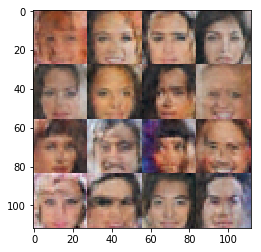

Epoch 0/1... Discriminator Loss: 1.1185... Generator Loss: 1.0686
Epoch 0/1... Discriminator Loss: 1.4074... Generator Loss: 0.4688
Epoch 0/1... Discriminator Loss: 0.9800... Generator Loss: 1.6040
Epoch 0/1... Discriminator Loss: 0.8627... Generator Loss: 1.2324
Epoch 0/1... Discriminator Loss: 1.0104... Generator Loss: 1.0108
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


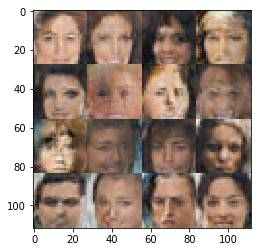

Epoch 0/1... Discriminator Loss: 1.1721... Generator Loss: 0.6891
Epoch 0/1... Discriminator Loss: 1.0649... Generator Loss: 1.3180
Epoch 0/1... Discriminator Loss: 0.9363... Generator Loss: 1.1145
Epoch 0/1... Discriminator Loss: 1.0157... Generator Loss: 1.1463
Epoch 0/1... Discriminator Loss: 1.1872... Generator Loss: 0.6878
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


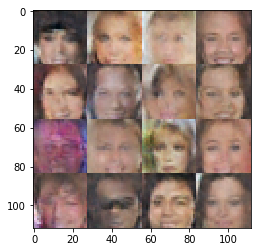

Epoch 0/1... Discriminator Loss: 1.1366... Generator Loss: 0.7333
Epoch 0/1... Discriminator Loss: 1.1888... Generator Loss: 0.6410
Epoch 0/1... Discriminator Loss: 0.8411... Generator Loss: 1.5347
Epoch 0/1... Discriminator Loss: 1.0962... Generator Loss: 0.7935
Epoch 0/1... Discriminator Loss: 0.9392... Generator Loss: 1.1614
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


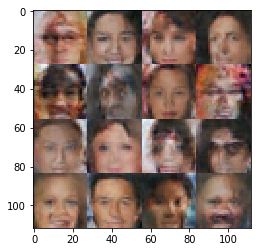

Epoch 0/1... Discriminator Loss: 0.8885... Generator Loss: 1.4430
Epoch 0/1... Discriminator Loss: 1.0055... Generator Loss: 1.1462
Epoch 0/1... Discriminator Loss: 1.0101... Generator Loss: 0.8900
Epoch 0/1... Discriminator Loss: 0.9021... Generator Loss: 1.7256
Epoch 0/1... Discriminator Loss: 0.9131... Generator Loss: 1.4540
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


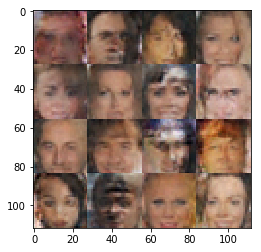

Epoch 0/1... Discriminator Loss: 1.0381... Generator Loss: 1.0623
Epoch 0/1... Discriminator Loss: 0.9251... Generator Loss: 1.0376
Epoch 0/1... Discriminator Loss: 0.9544... Generator Loss: 1.2241
Epoch 0/1... Discriminator Loss: 0.8845... Generator Loss: 1.4095
Epoch 0/1... Discriminator Loss: 0.9025... Generator Loss: 1.2202
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


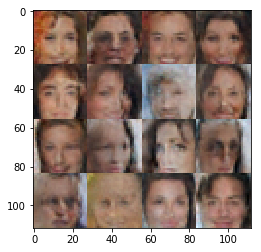

Epoch 0/1... Discriminator Loss: 1.2918... Generator Loss: 0.5289
Epoch 0/1... Discriminator Loss: 1.0200... Generator Loss: 0.7495
Epoch 0/1... Discriminator Loss: 1.4113... Generator Loss: 0.4556
Epoch 0/1... Discriminator Loss: 0.9303... Generator Loss: 1.2727
Epoch 0/1... Discriminator Loss: 1.0837... Generator Loss: 0.9037
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


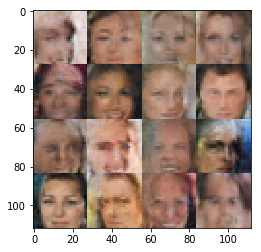

Epoch 0/1... Discriminator Loss: 0.9604... Generator Loss: 1.1914
Epoch 0/1... Discriminator Loss: 1.0527... Generator Loss: 1.1825
Epoch 0/1... Discriminator Loss: 0.8752... Generator Loss: 1.2237
Epoch 0/1... Discriminator Loss: 1.2641... Generator Loss: 0.5910
Epoch 0/1... Discriminator Loss: 0.9943... Generator Loss: 1.9292
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


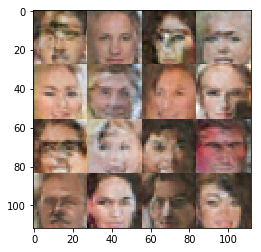

Epoch 0/1... Discriminator Loss: 1.3513... Generator Loss: 0.4793
Epoch 0/1... Discriminator Loss: 1.0542... Generator Loss: 1.2050
Epoch 0/1... Discriminator Loss: 1.1636... Generator Loss: 0.8197
Epoch 0/1... Discriminator Loss: 1.0268... Generator Loss: 1.1154
Epoch 0/1... Discriminator Loss: 1.1285... Generator Loss: 0.7202
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


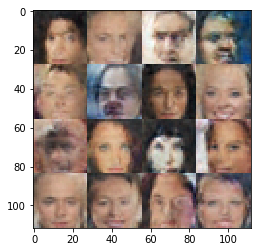

Epoch 0/1... Discriminator Loss: 1.3146... Generator Loss: 0.5579
Epoch 0/1... Discriminator Loss: 0.9948... Generator Loss: 1.1699
Epoch 0/1... Discriminator Loss: 0.9490... Generator Loss: 1.0805
Epoch 0/1... Discriminator Loss: 0.8419... Generator Loss: 1.5449
Epoch 0/1... Discriminator Loss: 1.1931... Generator Loss: 1.2425
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


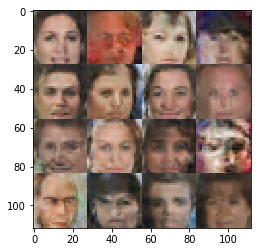

Epoch 0/1... Discriminator Loss: 0.9137... Generator Loss: 1.2795
Epoch 0/1... Discriminator Loss: 1.3636... Generator Loss: 0.7460
Epoch 0/1... Discriminator Loss: 1.0464... Generator Loss: 1.0249
Epoch 0/1... Discriminator Loss: 0.9173... Generator Loss: 1.2377
Epoch 0/1... Discriminator Loss: 0.9047... Generator Loss: 1.0053
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


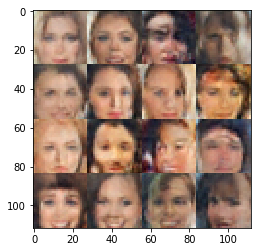

Epoch 0/1... Discriminator Loss: 0.9141... Generator Loss: 1.1759
Epoch 0/1... Discriminator Loss: 1.2703... Generator Loss: 2.0214
Epoch 0/1... Discriminator Loss: 0.8654... Generator Loss: 1.3473
Epoch 0/1... Discriminator Loss: 0.9902... Generator Loss: 0.8601
Epoch 0/1... Discriminator Loss: 1.2219... Generator Loss: 1.0406
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


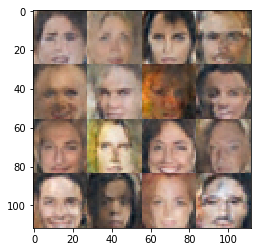

Epoch 0/1... Discriminator Loss: 0.7711... Generator Loss: 1.4177
Epoch 0/1... Discriminator Loss: 0.8982... Generator Loss: 1.2259
Epoch 0/1... Discriminator Loss: 0.9685... Generator Loss: 1.0050
Epoch 0/1... Discriminator Loss: 1.4035... Generator Loss: 0.5012
Epoch 0/1... Discriminator Loss: 1.3357... Generator Loss: 0.5070
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


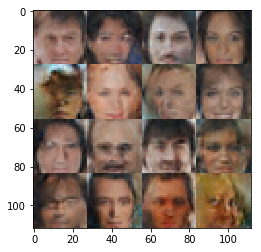

Epoch 0/1... Discriminator Loss: 0.9170... Generator Loss: 1.4615
Epoch 0/1... Discriminator Loss: 0.9793... Generator Loss: 1.2686
Epoch 0/1... Discriminator Loss: 0.8227... Generator Loss: 1.0696
Epoch 0/1... Discriminator Loss: 1.1361... Generator Loss: 0.7688
Epoch 0/1... Discriminator Loss: 0.9824... Generator Loss: 1.4687
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


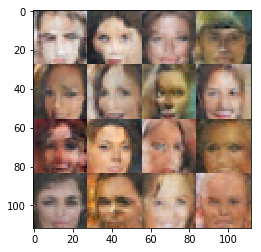

Epoch 0/1... Discriminator Loss: 1.1058... Generator Loss: 0.8168
Epoch 0/1... Discriminator Loss: 1.0881... Generator Loss: 0.7966
CPU times: user 7min 33s, sys: 1min 30s, total: 9min 4s
Wall time: 10min 37s


In [13]:
%%time
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
alpha=0.2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
print("finished loading images.")

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.